In [1]:
import numpy as np
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from sklearn.preprocessing import StandardScaler

exp_dir = 'experiments/purchase/purchase_res/'
all_preds = [f for f in os.listdir(exp_dir) if f.endswith('.p')]
print(all_preds)
c = 0.0005

['10_1000_sgd_sgd_predictions.p', '20_1000_sgd_sgd_predictions.p', '80_1000_sgd_sgd_only_predictions.p', '40_1000_sgd_sgd_predictions.p', '20_1000_sgd_sgd_only_predictions.p', '160_1000_sgd_sgd_only_predictions.p', '40_1000_sgd_sgd_only_predictions.p', '160_1000_sgd_sgd_predictions.p', '320_1000_sgd_sgd_only_predictions.p', '80_1000_sgd_sgd_predictions.p', '10_1000_sgd_sgd_only_predictions.p', '320_1000_sgd_sgd_predictions.p']


In [9]:
def get_config(fname):
    return 'only' in fname, int(fname.split('_')[0])

def sort_predictions_diff(up_preds, orig_preds, concat=False):
    sorted_diffs = []
    for up, orig in zip(up_preds, orig_preds):
        inds = np.argsort(up)
        if concat:
            sorted_diffs.append(np.concatenate([up[inds], orig[inds]]))
        else:
            sorted_diffs.append(up[inds] - orig[inds])
            assert up[inds].max()==up[inds][-1]
    return np.array(sorted_diffs)

def dummy_get_features(up_preds, orig_preds, up_class, orig_class):
    return_pred = False
    diffs = get_loss(up_preds, up_class, return_pred) - get_loss(orig_preds, orig_class, return_pred)
    ratios = (c + get_loss(up_preds, up_class, return_pred))/(c + get_loss(orig_preds, orig_class, return_pred))
    return np.concatenate([diffs[:, None], ratios[:, None]], axis=1)

def train_model(features, labels, model_type):
    if model_type=='mlp':
        model = MLPClassifier(hidden_layer_sizes=(10,))
    elif model_type=='lr':
        model = LogisticRegression()
    elif model_type=='dt':
        model = DecisionTreeClassifier()
    else:
        assert model_type=='rf'
        model = RandomForestClassifier()
    model.fit(features, labels)
    return model

def run_loss_diff_ratio(update_predictions, orig_predictions):
    IN_up_losses = [get_loss(up[0][0], up[0][1]) for up in update_predictions]
    IN_orig_losses = [get_loss(orig[0][0], orig[0][1]) for orig in orig_predictions]
    OUT_up_losses = [get_loss(up[1][0], up[1][1]) for up in update_predictions]
    OUT_orig_losses = [get_loss(orig[1][0], orig[1][1]) for orig in orig_predictions]
    
    shadow_diffs_IN = IN_up_losses[0] - IN_orig_losses[0]
    shadow_diffs_OUT = OUT_up_losses[0] - OUT_orig_losses[0]    
    shadow_thresh_diff = np.median(np.array([shadow_diffs_IN, shadow_diffs_OUT]))

    shadow_ratios_IN = (c + IN_up_losses[0])/(c + IN_orig_losses[0])
    shadow_ratios_OUT = (c + OUT_up_losses[0])/(c + OUT_orig_losses[0])
    shadow_thresh_ratio = np.median(np.array([shadow_ratios_IN, shadow_ratios_OUT]))

    loss_diff_ct = 0
    loss_ratio_ct = 0
    max_trial = 10 # len(IN_up_losses)
    for ind in range(1, max_trial):
        IN_up_loss, IN_orig_loss = IN_up_losses[ind], IN_orig_losses[ind]
        OUT_up_loss, OUT_orig_loss = OUT_up_losses[ind], OUT_orig_losses[ind]
        
        IN_loss_diff, OUT_loss_diff = IN_up_loss - IN_orig_loss, OUT_up_loss - OUT_orig_loss
        loss_diff_ct += (IN_loss_diff<shadow_thresh_diff).sum() + (OUT_loss_diff>=shadow_thresh_diff).sum()
        
        IN_loss_ratio = (c + IN_up_loss)/(c + IN_orig_loss)
        OUT_loss_ratio = (c + OUT_up_loss)/(c + OUT_orig_loss)
        loss_ratio_ct += (IN_loss_ratio<shadow_thresh_ratio).sum() + (OUT_loss_ratio>=shadow_thresh_ratio).sum()
    total_ct = 2*(max_trial - 1)*IN_up_losses[0].shape[0]
    return loss_diff_ct/total_ct, loss_ratio_ct/total_ct
        
    
def get_loss(pred, lab, return_pred=False):
    cls_pred = np.multiply(pred, np.eye(10)[lab]).sum(axis=1)
    loss = -np.log(cls_pred)
    if return_pred:
        return cls_pred
    return loss

def run_chen_attack(update_predictions, orig_predictions, num_shadows=1, model_type='lr'):
    use_dummy = False
    if use_dummy:
        IN_features = [dummy_get_features(up[0][0], orig[0][0], up[0][1], orig[0][1]) for (up, orig) in zip(update_predictions, orig_predictions)]
        OUT_features = [dummy_get_features(up[1][0], orig[1][0], up[1][1], orig[1][1]) for (up, orig) in zip(update_predictions, orig_predictions)]
    else:
        IN_features = [sort_predictions_diff(up[0][0], orig[0][0]) for (up, orig) in zip(update_predictions, orig_predictions)]
        OUT_features = [sort_predictions_diff(up[1][0], orig[1][0]) for (up, orig) in zip(update_predictions, orig_predictions)]
    
    
    train_IN_features, train_OUT_features = IN_features[:num_shadows], OUT_features[:num_shadows]
    
    test_IN_features, test_OUT_features = IN_features[num_shadows:], OUT_features[num_shadows:]
    
    if use_dummy:
        train_features = np.concatenate(train_IN_features + train_OUT_features)[:, None]
        test_features = np.concatenate(test_IN_features + test_OUT_features)[:, None]
    else:
        train_features = np.concatenate(train_IN_features + train_OUT_features)
        test_features = np.concatenate(test_IN_features + test_OUT_features)
    scaler = StandardScaler().fit(train_features)
    train_features, test_features = scaler.transform(train_features), scaler.transform(test_features)

    num_train, num_test = train_features.shape[0], test_features.shape[0]
    
    train_labels = np.zeros(num_train)
    train_labels[:num_train//2] = 1
    test_labels = np.zeros(num_test)
    test_labels[:num_test//2] = 1
    
    model = train_model(train_features, train_labels, model_type)
    return model.score(test_features, test_labels)

def augmented_chen_attack(update_predictions, orig_predictions, num_shadows, model_type):
    dummy_IN_features = [dummy_get_features(up[0][0], orig[0][0], up[0][1], orig[0][1]) for (up, orig) in zip(update_predictions, orig_predictions)]
    dummy_OUT_features = [dummy_get_features(up[1][0], orig[1][0], up[1][1], orig[1][1]) for (up, orig) in zip(update_predictions, orig_predictions)]
    chen_IN_features = [sort_predictions_diff(up[0][0], orig[0][0]) for (up, orig) in zip(update_predictions, orig_predictions)]
    chen_OUT_features = [sort_predictions_diff(up[1][0], orig[1][0]) for (up, orig) in zip(update_predictions, orig_predictions)]

    IN_features = [np.concatenate([dummy, chen], axis=1) for dummy, chen in zip(dummy_IN_features, chen_IN_features)]
    OUT_features = [np.concatenate([dummy, chen], axis=1) for dummy, chen in zip(dummy_OUT_features, chen_OUT_features)]
        
    train_IN_features, train_OUT_features = IN_features[:num_shadows], OUT_features[:num_shadows]
    
    test_IN_features, test_OUT_features = IN_features[num_shadows:], OUT_features[num_shadows:]
    
    train_features = np.concatenate(train_IN_features + train_OUT_features)
    scaler = StandardScaler().fit(train_features)

    test_features = np.concatenate(test_IN_features + test_OUT_features)
    train_features, test_features = scaler.transform(train_features), scaler.transform(test_features)
    
    num_train, num_test = train_features.shape[0], test_features.shape[0]
    
    train_labels = np.zeros(num_train)
    train_labels[:num_train//2] = 1
    test_labels = np.zeros(num_test)
    test_labels[:num_test//2] = 1
    model = train_model(train_features, train_labels, model_type)
    if model_type!='lr':
        return model.score(test_features, test_labels), None
    return model.score(test_features, test_labels), model.coef_

In [3]:
all_res = {}
all_aug_res = {}
all_loss_res = {}

for pred_f in sorted(all_preds, key=get_config):
    print(get_config(pred_f))
    update_predictions, orig_predictions = pickle.load(open(os.path.join(exp_dir, pred_f), 'rb'))
    shadow_cts = [1, 2, 3, 4, 5, 10, 20, 30]
    model_types = ['dt', 'rf', 'lr', 'mlp']  #  ['dt', 'rf', 'lr', 'mlp']
    all_loss_res[get_config(pred_f)] = run_loss_diff_ratio(update_predictions, orig_predictions)
    for num_shadows, model_type in product(shadow_cts, model_types):
        res = run_chen_attack(update_predictions, orig_predictions, num_shadows, model_type)
        all_res[get_config(pred_f), num_shadows, model_type] = res
    aug_res, _ = augmented_chen_attack(update_predictions, orig_predictions, 30, 'lr')
    all_aug_res[get_config(pred_f)] = aug_res


(False, 10)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(False, 20)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(False, 40)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(False, 80)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(False, 160)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(False, 320)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(True, 10)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(True, 20)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(True, 40)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(True, 80)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(True, 160)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(True, 320)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(False, 10)


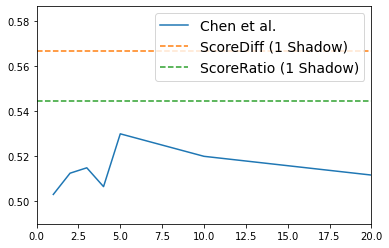

(False, 20)


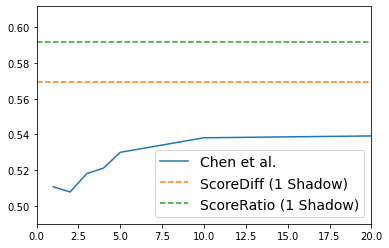

(False, 40)


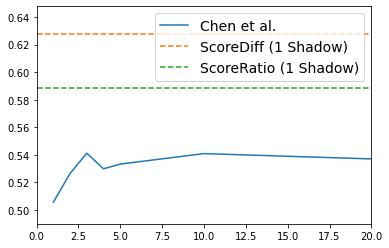

(False, 80)


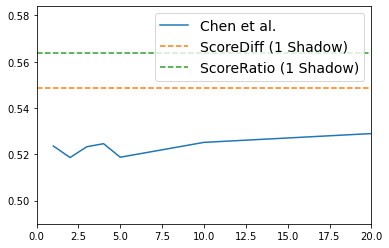

(False, 160)


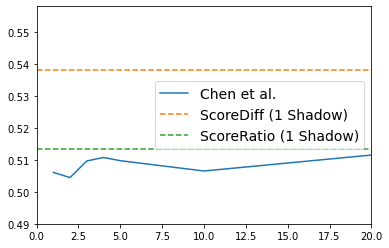

(False, 320)


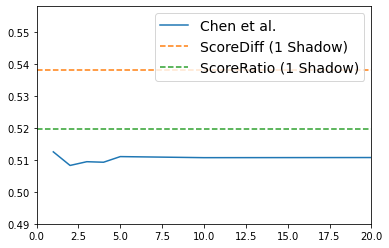

(True, 10)


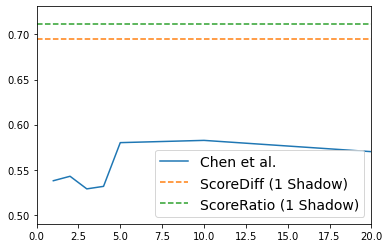

(True, 20)


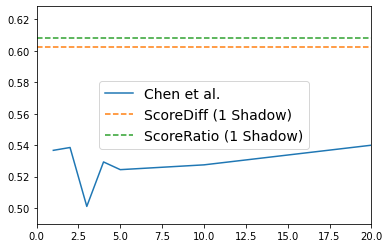

(True, 40)


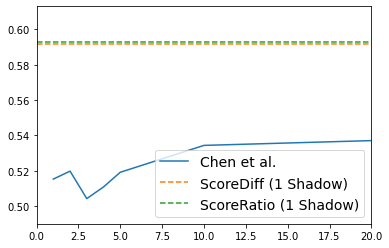

(True, 80)


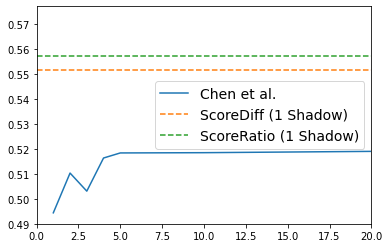

(True, 160)


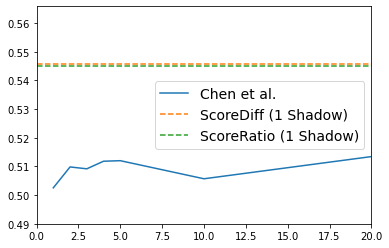

(True, 320)


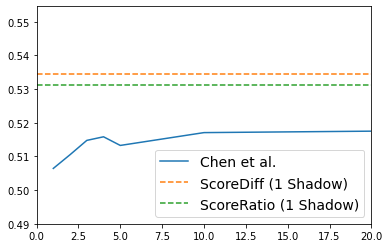

In [5]:
# plot their accuracy as a function of shadow models
import matplotlib.pyplot as plt
shadow_cts = [1, 2, 3, 4, 5, 10, 20]
model_types = ['dt', 'rf', 'lr', 'mlp']

max_chen_by_key = {}
aug_by_key = {}

for key in all_loss_res:
    print(key)
    loss_res = all_loss_res[key]
    best_chens = []
    for num_shadows in shadow_cts:
        best_chen_res = 0
        all_chen_res = 0
        for model_type in model_types:
            chen_res = all_res[key, num_shadows, model_type]
            best_chen_res = max(chen_res, best_chen_res)
            all_chen_res += chen_res/4
        best_chens.append(best_chen_res)
        #best_chens.append(all_chen_res)
    max_chen_by_key[key] = max(best_chens)
    plt.plot(shadow_cts, best_chens, label='Chen et al.')
    plt.plot([0, 100], [loss_res[0], loss_res[0]], linestyle='--', label='ScoreDiff (1 Shadow)')
    plt.plot([0, 100], [loss_res[1], loss_res[1]], linestyle='--', label='ScoreRatio (1 Shadow)')
    plt.legend(fontsize=14)
    plt.xlim(0, max(shadow_cts))
    plt.ylim(0.49, max(loss_res)+0.02)
    plt.show()

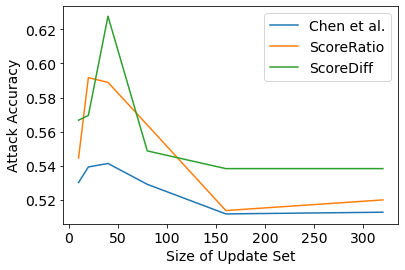

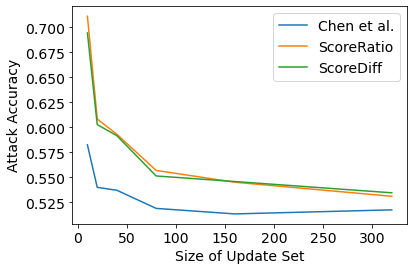

In [7]:
update_sizes = [250, 500, 1000, 2000, 4000, 8000]
for update_alg in [False, True]:
    loss_ratios = []
    loss_diffs = []
    chen_accs = []
    aug_accs = []
    for up_size in update_sizes:
        chen_accs.append(max_chen_by_key[update_alg, up_size])
        loss_ratios.append(all_loss_res[update_alg, up_size][1])
        loss_diffs.append(all_loss_res[update_alg, up_size][0])
        aug_accs.append(all_aug_res[update_alg, up_size])
    plt.plot(update_sizes, chen_accs, label="Chen et al.")
    plt.plot(update_sizes, loss_ratios, label="ScoreRatio")
    plt.plot(update_sizes, loss_diffs, label="ScoreDiff")
    #plt.plot(update_sizes, aug_accs, label="Improved Chen et al.")

    plt.xlabel("Size of Update Set", fontsize=14)
    plt.ylabel("Attack Accuracy", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.show()

In [13]:
all_feature_sums = []
all_our_sum = []

for pred_f in sorted(all_preds, key=get_config):
    print(get_config(pred_f))
    update_predictions, orig_predictions = pickle.load(open(os.path.join(exp_dir, pred_f), 'rb'))
    num_shadows = 30
    model_type = 'lr'
    _, coef = augmented_chen_attack(update_predictions, orig_predictions, num_shadows, model_type)
    our_feature_val = np.abs(coef)[0][:2].mean()
    all_our_sum.append(our_feature_val)
    all_feature_vals = np.abs(coef)[0][2:].mean()
    all_feature_sums.append(all_feature_vals)
    #print(our_feature_val/all_feature_vals)
print(np.mean(all_our_sum)/np.mean(all_feature_sums))
print([a/b for a, b in zip(all_our_sum, all_feature_sums)])

(False, 10)
(False, 20)
(False, 40)
(False, 80)
(False, 160)
(False, 320)
(True, 10)
(True, 20)
(True, 40)
(True, 80)
(True, 160)
(True, 320)
7.500363411851508
[4.999226892929543, 7.276552342764383, 14.005838684699413, 12.384257361207178, 8.097493706025746, 7.952782796183093, 5.7765176026989415, 8.01358543943856, 10.227655281201098, 7.072010527138917, 9.973851299925785, 8.248080859733014]


In [1]:
import numpy as np

chen_only = np.load('chen_True.npy', allow_pickle=True)
chen_full = np.load('chen_False.npy', allow_pickle=True)

diff_only = np.load('diff_True.npy', allow_pickle=True)
diff_full = np.load('diff_False.npy', allow_pickle=True)

ratio_only = np.load('ratio_True.npy', allow_pickle=True)
ratio_full = np.load('ratio_False.npy', allow_pickle=True)

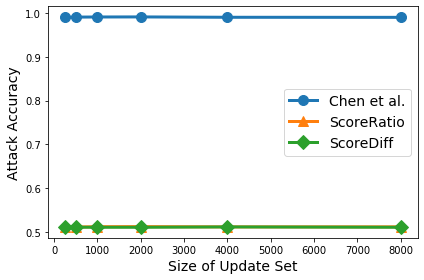

In [5]:
import matplotlib.pyplot as plt

update_sizes = [250, 500, 1000, 2000, 4000, 8000]

plt.plot(
    update_sizes,
    chen_only,
    "o",
    label="Chen et al.",
    linestyle="-",
    linewidth=3,
    markersize=10,
)
plt.plot(
    update_sizes,
    ratio_only,
    "^",
    label="ScoreRatio",
    linestyle="-",
    linewidth=3,
    markersize=10,
)
plt.plot(
    update_sizes,
    diff_only,
    "D",
    label="ScoreDiff",
    linestyle="-",
    linewidth=3,
    markersize=10,
)

plt.xlabel("Size of Update Set", fontsize=14)
plt.ylabel("Attack Accuracy", fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"purchase_chen_sgd_only.png")
plt.show()

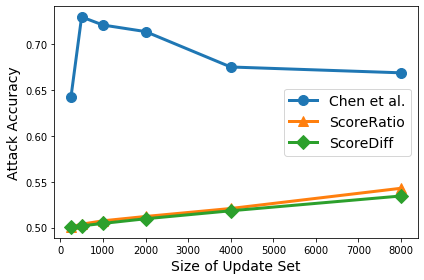

In [6]:
plt.plot(
    update_sizes,
    chen_full,
    "o",
    label="Chen et al.",
    linestyle="-",
    linewidth=3,
    markersize=10,
)
plt.plot(
    update_sizes,
    ratio_full,
    "^",
    label="ScoreRatio",
    linestyle="-",
    linewidth=3,
    markersize=10,
)
plt.plot(
    update_sizes,
    diff_full,
    "D",
    label="ScoreDiff",
    linestyle="-",
    linewidth=3,
    markersize=10,
)

plt.xlabel("Size of Update Set", fontsize=14)
plt.ylabel("Attack Accuracy", fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"purchase_chen_sgd_full.png")
plt.show()

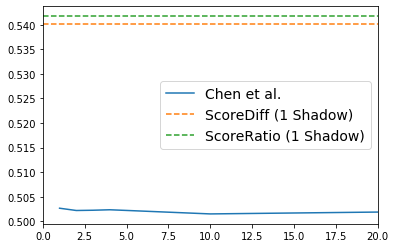

In [25]:
import numpy as np
import matplotlib.pyplot as plt

shadow_cts = [1, 2, 3, 4, 5, 10, 20]

plt.plot(shadow_cts, np.load('chen_shadow_(False, 250).npy', allow_pickle=True)[1], label="Chen et al.")
ds = np.load('scorediff_shadow(False, 250).npy', allow_pickle=True)

plt.plot(
    [0, 100],
    [0.54016666666666661, 0.5401666666666666],
    linestyle="--",
    label="ScoreDiff (1 Shadow)",
)
ds = np.load('scoreratio_shadow(False, 250).npy', allow_pickle=True)
plt.plot(
    [0, 100],
    [0.5417333333333333, 0.5417333333333333],
    linestyle="--",
    label="ScoreRatio (1 Shadow)",
)
plt.legend(fontsize=14)
plt.xlim(0, max(shadow_cts))
# plt.ylim(0.49, max(ds[0]) + 0.02)
plt.show()

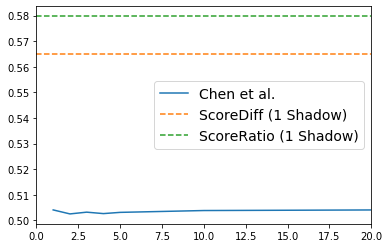

In [26]:
import numpy as np
import matplotlib.pyplot as plt

shadow_cts = [1, 2, 3, 4, 5, 10, 20]

plt.plot(shadow_cts, np.load('chen_shadow_(True, 250).npy', allow_pickle=True)[1], label="Chen et al.")
ds = np.load('scorediff_shadow(True, 250).npy', allow_pickle=True)

plt.plot(
    [0, 100],
    [0.5648, 0.5648],
    linestyle="--",
    label="ScoreDiff (1 Shadow)",
)
ds = np.load('scoreratio_shadow(True, 250).npy', allow_pickle=True)
plt.plot(
    [0, 100],
    [0.5797333333333334, 0.5797333333333334],
    linestyle="--",
    label="ScoreRatio (1 Shadow)",
)
plt.legend(fontsize=14)
plt.xlim(0, max(shadow_cts))
# plt.ylim(0.49, max(ds[0]) + 0.02)
plt.show()

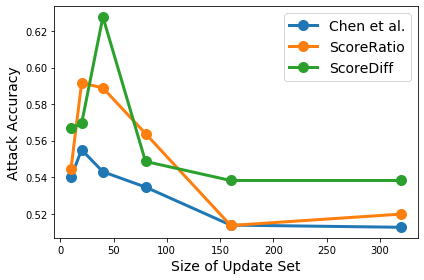

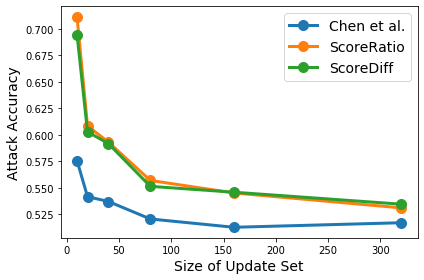

In [28]:
ds = [10, 20, 40, 80, 160, 320]

chen_sgd_full = [0.54, 0.555, 0.54296875, 0.5345833333333333, 0.5137632978723404, 0.512563775510204]
ratio_sgd_full = [0.5444444444444444, 0.5916666666666667, 0.5888888888888889, 0.5638888888888889, 0.5135416666666667, 0.5197916666666667]
diff_sgd_full = [0.5666666666666667, 0.5694444444444444, 0.6277777777777778, 0.5486111111111112, 0.5381944444444444, 0.5381944444444444]

chen_sgd_only = [0.5755555555555556, 0.5416666666666666, 0.5370833333333334, 0.520625, 0.5127777777777778, 0.5170703125]
ratio_sgd_only = [0.7111111111111111, 0.6083333333333333, 0.5930555555555556, 0.5569444444444445, 0.5451388888888888, 0.5310763888888889]
diff_sgd_only = [0.6944444444444444, 0.6027777777777777, 0.5916666666666667, 0.5513888888888889, 0.5458333333333333, 0.5345486111111111]

plt.plot(ds, chen_sgd_full, 
         'o', label='Chen et al.', 
         linestyle='-', linewidth=3, markersize=10)
plt.plot(ds, ratio_sgd_full, 
         'o', label='ScoreRatio', 
         linestyle='-', linewidth=3, markersize=10)
plt.plot(ds, diff_sgd_full, 
         'o', label='ScoreDiff', 
         linestyle='-', linewidth=3, markersize=10)
plt.xlabel('Size of Update Set', fontsize=14)
plt.ylabel('Attack Accuracy', fontsize=14) 
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('chen_sgd_full.png')
plt.show()

plt.clf()
plt.plot(ds, chen_sgd_only, 
         'o', label='Chen et al.', 
         linestyle='-', linewidth=3, markersize=10)
plt.plot(ds, ratio_sgd_only, 
         'o', label='ScoreRatio', 
         linestyle='-', linewidth=3, markersize=10)
plt.plot(ds, diff_sgd_only, 
         'o', label='ScoreDiff', 
         linestyle='-', linewidth=3, markersize=10)
plt.xlabel('Size of Update Set', fontsize=14)
plt.ylabel('Attack Accuracy', fontsize=14) 
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('chen_sgd_new.png')
plt.show()